# **Laboratorio 6**

Edwin Ortega, 22305 - Esteban Zambrano, 22119 - Juan Pablo Solis, 22102


### Ejercicio 1

##### Imports y parámetros

In [34]:
%matplotlib agg

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import io
from math import exp

# Parámetros
SEED       = 42          # Semilla reproducible
L          = 40.0        # Tamaño del cuadrado [0,L]x[0,L]
N          = 400         # Número de partículas
I0         = 5           # Infectados iniciales
V_MAX      = 1.5         # Velocidad máxima
R_CONTAGIO = 2.0         # Radio de contagio
BETA       = 0.8         # Tasa de infección
GAMMA      = 0.1         # Tasa de recuperación
DT         = 0.1         # Paso de tiempo
T_TOTAL    = 200.0       # Duración de la simulación
FRAME_EVERY = 5          # Guardar 1 frame cada k pasos para el GIF

# Colores por estado: 0=S, 1=I, 2=R
COLORS = np.array([
    [0.2, 0.2, 0.9],  # S - azul
    [0.9, 0.2, 0.2],  # I - rojo
    [0.2, 0.6, 0.2],  # R - verde
], dtype=float)

rng = np.random.default_rng(SEED)

##### Utilidades (fronteras, inicialización, un paso de dinámica)

In [36]:
def reflect_boundary(pos, vel, L):
    """
    Frontera reflectante: si sale del dominio, rebota y cambia el signo de la velocidad.
    """
    for d in range(2):
        over = pos[:, d] > L
        pos[over, d] = 2*L - pos[over, d]
        vel[over, d] *= -1.0

        under = pos[:, d] < 0.0
        pos[under, d] = -pos[under, d]
        vel[under, d] *= -1.0

def initialize_system(N, I0, L, V_MAX, rng):
    """
    Posiciones uniformes en el cuadrado, direcciones aleatorias y velocidades en [0.2*V_MAX, V_MAX].
    Estados: 0=S, 1=I, 2=R. Se marcan I0 infectados al inicio.
    """
    pos = rng.uniform(0, L, size=(N, 2))
    angles = rng.uniform(0, 2*np.pi, size=N)
    speeds = rng.uniform(0.2*V_MAX, V_MAX, size=N)
    vel = np.column_stack((np.cos(angles), np.sin(angles))) * speeds[:, None]

    states = np.zeros(N, dtype=np.int8)
    infected_idx = rng.choice(N, size=I0, replace=False)
    states[infected_idx] = 1
    return pos, vel, states

def step(pos, vel, states, L, r, beta, gamma, dt, rng):
    """
    1) Mover + reflejar
    2) Contagio: S cerca de I (distancia <= r) se infecta con probabilidad 1-exp(-beta*dt)
    3) Recuperación: I -> R con probabilidad 1-exp(-gamma*dt)
    """
    # Mover
    pos += vel * dt
    reflect_boundary(pos, vel, L)

    # Contagio
    p_inf = 1.0 - exp(-beta * dt)
    infected = (states == 1)
    susceptible = (states == 0)

    if infected.any() and susceptible.any():
        I_idx = np.where(infected)[0]
        S_idx = np.where(susceptible)[0]

        # O(N^2) ingenuo: suficiente para N~400. Si N crece, usar celdas/espacial hashing.
        dI = pos[I_idx][:, None, :] - pos[S_idx][None, :, :]
        dist2 = np.sum(dI**2, axis=2)
        S_close_mask = (dist2 <= (r*r)).any(axis=0)
        S_close_idx = S_idx[S_close_mask]
        # Bernoulli por dt
        infect_draws = rng.random(len(S_close_idx)) < p_inf
        states[S_close_idx[infect_draws]] = 1

    # Recuperación
    p_rec = 1.0 - exp(-gamma * dt)
    I_idx = np.where(states == 1)[0]
    if I_idx.size:
        recov_mask = rng.random(I_idx.size) < p_rec
        states[I_idx[recov_mask]] = 2

##### Simulación + curvas S(t), I(t), R(t)

In [37]:
def simulate(N, I0, L, V_MAX, r, beta, gamma, dt, T, frame_every, seed):
    rng_local = np.random.default_rng(seed)
    pos, vel, states = initialize_system(N, I0, L, V_MAX, rng_local)

    steps = int(T / dt)
    S_traj = np.empty(steps+1, dtype=int)
    I_traj = np.empty(steps+1, dtype=int)
    R_traj = np.empty(steps+1, dtype=int)

    # Estado inicial
    S_traj[0] = np.sum(states == 0)
    I_traj[0] = np.sum(states == 1)
    R_traj[0] = np.sum(states == 2)

    frames = []
    for k in range(1, steps+1):
        step(pos, vel, states, L, r, beta, gamma, dt, rng_local)
        S_traj[k] = np.sum(states == 0)
        I_traj[k] = np.sum(states == 1)
        R_traj[k] = np.sum(states == 2)

        if frame_every and (k % frame_every == 0):
            fig, ax = plt.subplots(figsize=(5,5))
            ax.set_xlim(0, L); ax.set_ylim(0, L)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(f"t = {k*dt:.1f}")
            ax.scatter(pos[:,0], pos[:,1], s=10, c=COLORS[states], edgecolors='none')
            buf = io.BytesIO()
            fig.savefig(buf, format="png")
            buf.seek(0)
            image = imageio.imread(buf)
            buf.close()
            frames.append(image)
            plt.close(fig)

    return {"pos": pos, "vel": vel, "states": states,
            "S": S_traj, "I": I_traj, "R": R_traj,
            "dt": dt, "frames": frames}

# Ejecutar
res = simulate(N, I0, L, V_MAX, R_CONTAGIO, BETA, GAMMA, DT, T_TOTAL, FRAME_EVERY, SEED)

# Curvas
time = np.arange(0, len(res["S"])) * DT
plt.figure(figsize=(7,4))
plt.plot(time, res["S"], label="S(t)")
plt.plot(time, res["I"], label="I(t)")
plt.plot(time, res["R"], label="R(t)")
plt.xlabel("Tiempo"); plt.ylabel("Población"); plt.title("Curvas SIR — Simulación por partículas")
plt.legend(); plt.tight_layout(); plt.show()

# Snapshot final
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(0, L); ax.set_ylim(0, L)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Estado final")
ax.scatter(res["pos"][:,0], res["pos"][:,1], s=10, c=COLORS[res['states']], edgecolors='none')
plt.show()

# Resumen rápido
R0 = BETA/GAMMA if GAMMA>0 else np.inf
print(f"R0 ≈ {R0:.2f} | pico I = {res['I'].max()} en t ≈ {time[res['I'].argmax()]:.1f}")


C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_16380\705616576.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


R0 ≈ 8.00 | pico I = 140 en t ≈ 18.9


C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_16380\705616576.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_16380\705616576.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


##### Guardar animación como GIF

In [38]:
gif_path = "sir_particles.gif"
if res["frames"]:
    imageio.mimsave(gif_path, res["frames"], fps=10)
    print(f"GIF guardado: {gif_path}")
else:
    print("No hay frames (sube T_TOTAL o baja FRAME_EVERY para generar frames).")

GIF guardado: sir_particles.gif



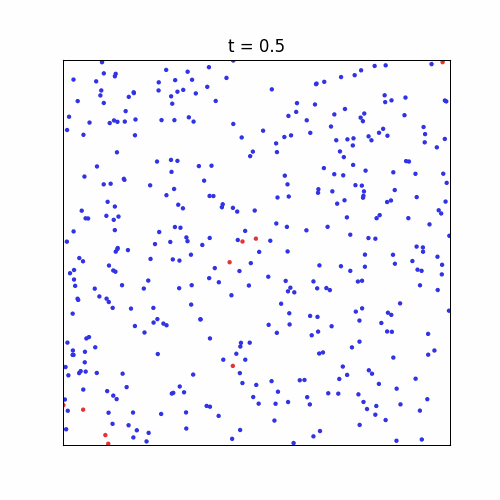
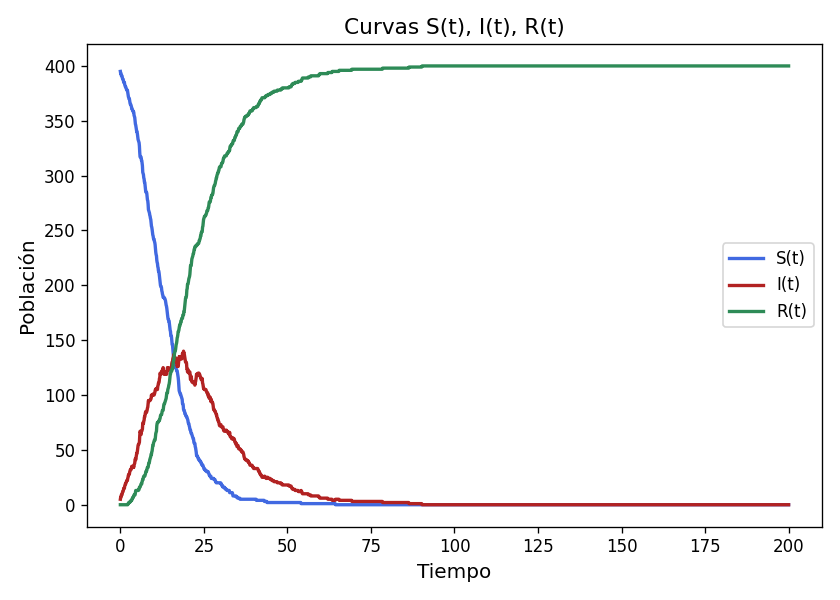

Resumen:
 - R₀ ≈ 8.00
 - Pico de I(t): 140 en t ≈ 18.9
 - Final: S=0, I=0, R=400


In [40]:
from IPython.display import HTML
import io, base64

# Crear el GIF en memoria
frames = res["frames"]
if len(frames) == 0:
    raise RuntimeError("No se generaron frames (aumenta T_TOTAL o reduce FRAME_EVERY).")

gif_bytes = io.BytesIO()
imageio.mimsave(gif_bytes, frames, format="gif", fps=10)
gif_bytes.seek(0)

# Figura de curvas SIR
fig, ax = plt.subplots(figsize=(7,5), dpi=120)
time = np.arange(0, len(res["S"])) * DT
ax.plot(time, res["S"], label="S(t)", color='royalblue', linewidth=2)
ax.plot(time, res["I"], label="I(t)", color='firebrick', linewidth=2)
ax.plot(time, res["R"], label="R(t)", color='seagreen', linewidth=2)
ax.set_xlabel("Tiempo", fontsize=12)
ax.set_ylabel("Población", fontsize=12)
ax.set_title("Curvas S(t), I(t), R(t)", fontsize=13)
ax.legend()
plt.tight_layout()

buf_plot = io.BytesIO()
plt.savefig(buf_plot, format='png')
buf_plot.seek(0)
plt.close(fig)

gif_b64  = base64.b64encode(gif_bytes.read()).decode("utf-8")
plot_b64 = base64.b64encode(buf_plot.read()).decode("utf-8")

# Mostrar gif y grafica
html = f"""
<div style="display:flex; justify-content:center; align-items:center; gap:20px;">
  <div style="flex: 1; text-align:center;">
    <img src="data:image/gif;base64,{gif_b64}" style="width:600px; height:auto;">
  </div>
  <div style="flex: 1; text-align:center;">
    <img src="data:image/png;base64,{plot_b64}" style="width:600px; height:auto;">
  </div>
</div>
"""
display(HTML(html))

# Resumen breve de la simulación
R0 = BETA / GAMMA if GAMMA > 0 else np.inf
peak_I, t_peak = res["I"].max(), time[res["I"].argmax()]
print("Resumen:")
print(f" - R₀ ≈ {R0:.2f}")
print(f" - Pico de I(t): {peak_I} en t ≈ {t_peak:.1f}")
print(f" - Final: S={res['S'][-1]}, I={res['I'][-1]}, R={res['R'][-1]}")


### Ejercicio 2

##### Autómata Celular SIR

In [5]:
# --- Reinicio rápido de variables previas ---
try:
    del grid, frames, S_hist, I_hist, R_hist
    print("Variables de simulación reiniciadas.")
except NameError:
    print("No había simulaciones anteriores cargadas.")


Variables de simulación reiniciadas.


C:\Users\esteb\AppData\Local\Temp\ipykernel_2792\3237335091.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(buf))



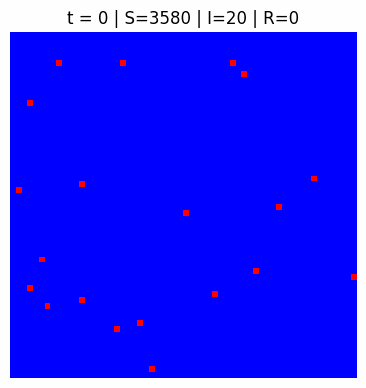
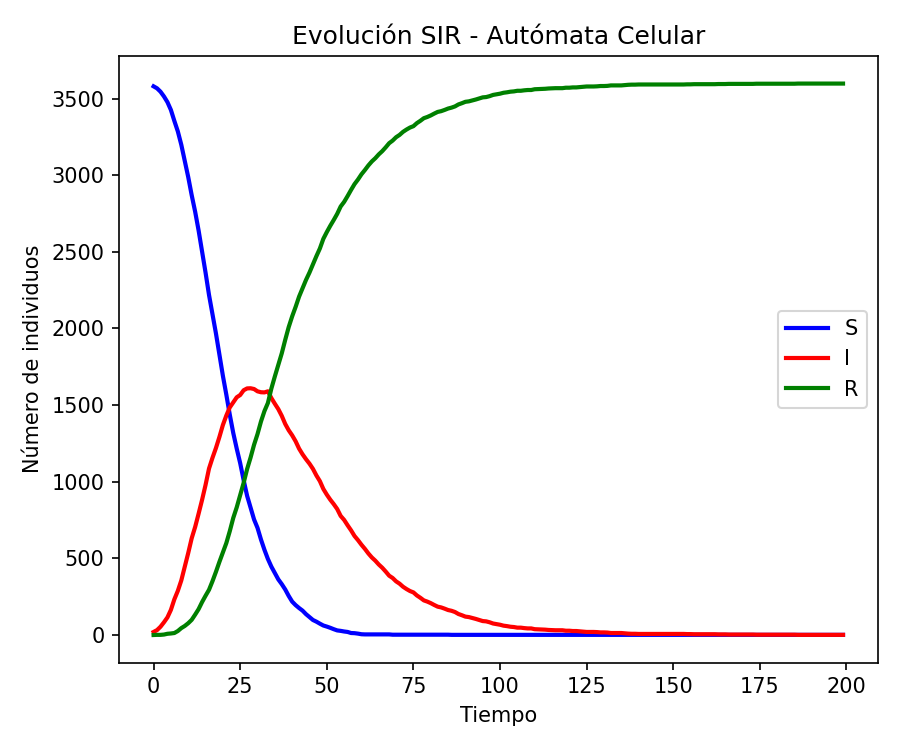

Resumen:
 - Grid: 60x60 | I0=20 | r=1 | beta=0.1 | gamma=0.05
 - Final: S=1, I=1, R=3598


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio, io, base64
from IPython.display import HTML

# Parámetros
M, N = 60, 60
I0 = 20
T = 200
r = 1
BETA = 0.1
GAMMA = 0.05
SEED = 42
rng = np.random.default_rng(SEED)

COLORS = np.array([[0,0,1],[1,0,0],[0,0.7,0]], dtype=float)

def inicializar_grid(M, N, I0):
    grid = np.zeros((M, N), dtype=np.int8)
    infectados = rng.choice(M*N, size=I0, replace=False)
    for idx in infectados:
        grid[idx//N, idx%N] = 1
    return grid

def vecinos_infectados(grid, i, j, r):
    M, N = grid.shape
    imin, imax = max(i-r,0), min(i+r+1,M)
    jmin, jmax = max(j-r,0), min(j+r+1,N)
    sub = grid[imin:imax, jmin:jmax]
    return np.sum(sub == 1)

def paso(grid, beta, gamma, r):
    M, N = grid.shape
    nuevo = grid.copy()
    for i in range(M):
        for j in range(N):
            if grid[i,j] == 0:  # S
                n_inf = vecinos_infectados(grid, i, j, r)
                if n_inf > 0:
                    p_inf = 1 - np.exp(-beta * n_inf)
                    if rng.random() < p_inf:
                        nuevo[i,j] = 1
            elif grid[i,j] == 1:  # I
                if rng.random() < gamma:
                    nuevo[i,j] = 2
    return nuevo

# --- Simulación ---
grid = inicializar_grid(M, N, I0)
frames = []
S_hist, I_hist, R_hist = [], [], []

for t in range(T):
    vals, counts = np.unique(grid, return_counts=True)
    d = dict(zip(vals, counts))
    S_hist.append(d.get(0,0)); I_hist.append(d.get(1,0)); R_hist.append(d.get(2,0))

    # frame (compat. con cualquier backend)
    fig, ax = plt.subplots(figsize=(4.5,4.5))
    ax.imshow(COLORS[grid], origin="upper")
    ax.set_title(f"t = {t} | S={S_hist[-1]} | I={I_hist[-1]} | R={R_hist[-1]}")
    ax.axis("off")
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
    buf.seek(0)
    frames.append(imageio.imread(buf))
    buf.close(); plt.close(fig)

    grid = paso(grid, BETA, GAMMA, r)

S_hist = np.array(S_hist); I_hist = np.array(I_hist); R_hist = np.array(R_hist)
time = np.arange(T)

# GIF en memoria
gif_bytes = io.BytesIO()
imageio.mimsave(gif_bytes, frames, format="gif", fps=10)
gif_bytes.seek(0); gif_b64 = base64.b64encode(gif_bytes.read()).decode("utf-8")

# Curvas
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(time, S_hist, label="S", color="blue", linewidth=2)
ax.plot(time, I_hist, label="I", color="red", linewidth=2)
ax.plot(time, R_hist, label="R", color="green", linewidth=2)
ax.set_xlabel("Tiempo"); ax.set_ylabel("Número de individuos")
ax.set_title("Evolución SIR - Autómata Celular"); ax.legend()
plt.tight_layout()
buf_plot = io.BytesIO(); plt.savefig(buf_plot, format='png', dpi=150); plt.close(fig)
plot_b64 = base64.b64encode(buf_plot.getvalue()).decode("utf-8")

# Mostrar lado a lado, mismo alto
html = f"""
<div style="display:flex; justify-content:center; align-items:center; gap:30px;">
  <img src="data:image/gif;base64,{gif_b64}" style="height:480px; width:auto;">
  <img src="data:image/png;base64,{plot_b64}" style="height:480px; width:auto;">
</div>
"""
display(HTML(html))

print(f"Resumen:")
print(f" - Grid: {M}x{N} | I0={I0} | r={r} | beta={BETA} | gamma={GAMMA}")
print(f" - Final: S={S_hist[-1]}, I={I_hist[-1]}, R={R_hist[-1]}")
